# CZ4042 Neural Networks & Deep Learning
## Assignment - 1: Part B, Question 1

> Gupta Jay  
> U1822549K  
> School of Computer Science and Engineering  
> Nanyang Technological University, Singapore  

## Imports

In [33]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from pathlib import Path

In [35]:
print(tf.__version__)

2.6.0


In [36]:
# Supress any warnings for clean presentation
import warnings
warnings.filterwarnings("ignore")

In [37]:
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [38]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Part A: Dividing the Dataset into Train/Test Splits

In [39]:
# Split data
train_dataframe = df[df['year'] <= 2020]
val_dataframe = df[df['year'] > 2020]

# Generate tf.data.Dataset objects for each dataframe
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

# Batch the datasets
train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

The validation data should be a good representative of the problem we are trying to solve. In the case of HDB prices, a trend is observerved where the prices are rising, in a broad based manner (irrespective of HDB type), and the pace of increase of prices is slowing down as well. Due to this, we have chosen our Test split from year 2021 onwards, such that it represents the trend, and is more representative of our problem.

Furthermore, with the broad-based manner of rising prices, we will have room for further evaluation as to whether the rising prices are a result of some attributes of the HDB flats. 

## Part B: 2-layer Neural Network with One-Hot Encoding

### Encoding Categorical & Numerical Features

In [40]:
# Categorical features (integers)
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical features encoded (integers)
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature (String)
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Categorical feature encoded (String)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

# Numerical Features Encoded
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

# Combining all inputs
all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

# Combining all Encoded inputs
all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

### 2-layer Feedforward Neural Network

In [41]:
def getModel(features, first_layer_activation, second_layer_activation):
    # Inputs -> Encoded Features (Concatenated) -> Dense -> Dense (Output)
    x = layers.Dense(10, activation=first_layer_activation)(features)
    output = layers.Dense(1, activation=second_layer_activation)(x)
    model = keras.Model(all_inputs, output)
    return model

def getOptimizer(lr):
    # Adam Optimizer (Default Parameters) -> Stochastic Gradient Descent
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    return optimizer

### Model Checkpoints & R2 Value Metric

In [42]:
checkpoint_filepath = 'nn-weights.{epoch:02d}'

# Callback to save model after each epoch
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=False,
    save_weights_only=False,
    save_freq="epoch")

def coeff_determination(y_true, y_pred):
    # Custom Metric to calculate R2 Value
    # Source: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    SS_res =  K.sum(K.square(y_true-y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

# Used later to restore model at the best epoch
def dummy_coeff_determination(y_true, y_pred):
    return 1

## Part C: Model Training

* **Loss Function**: Mean Squared Error
* **Learning Rate**: 0.05
* **Epochs**: 100
* **Batch Size**: 128 

In [43]:
loss = "mse"
metrics = [RootMeanSquaredError(), coeff_determination]
optimizer = getOptimizer(0.05)

model = getModel(all_features, "relu", "linear")
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

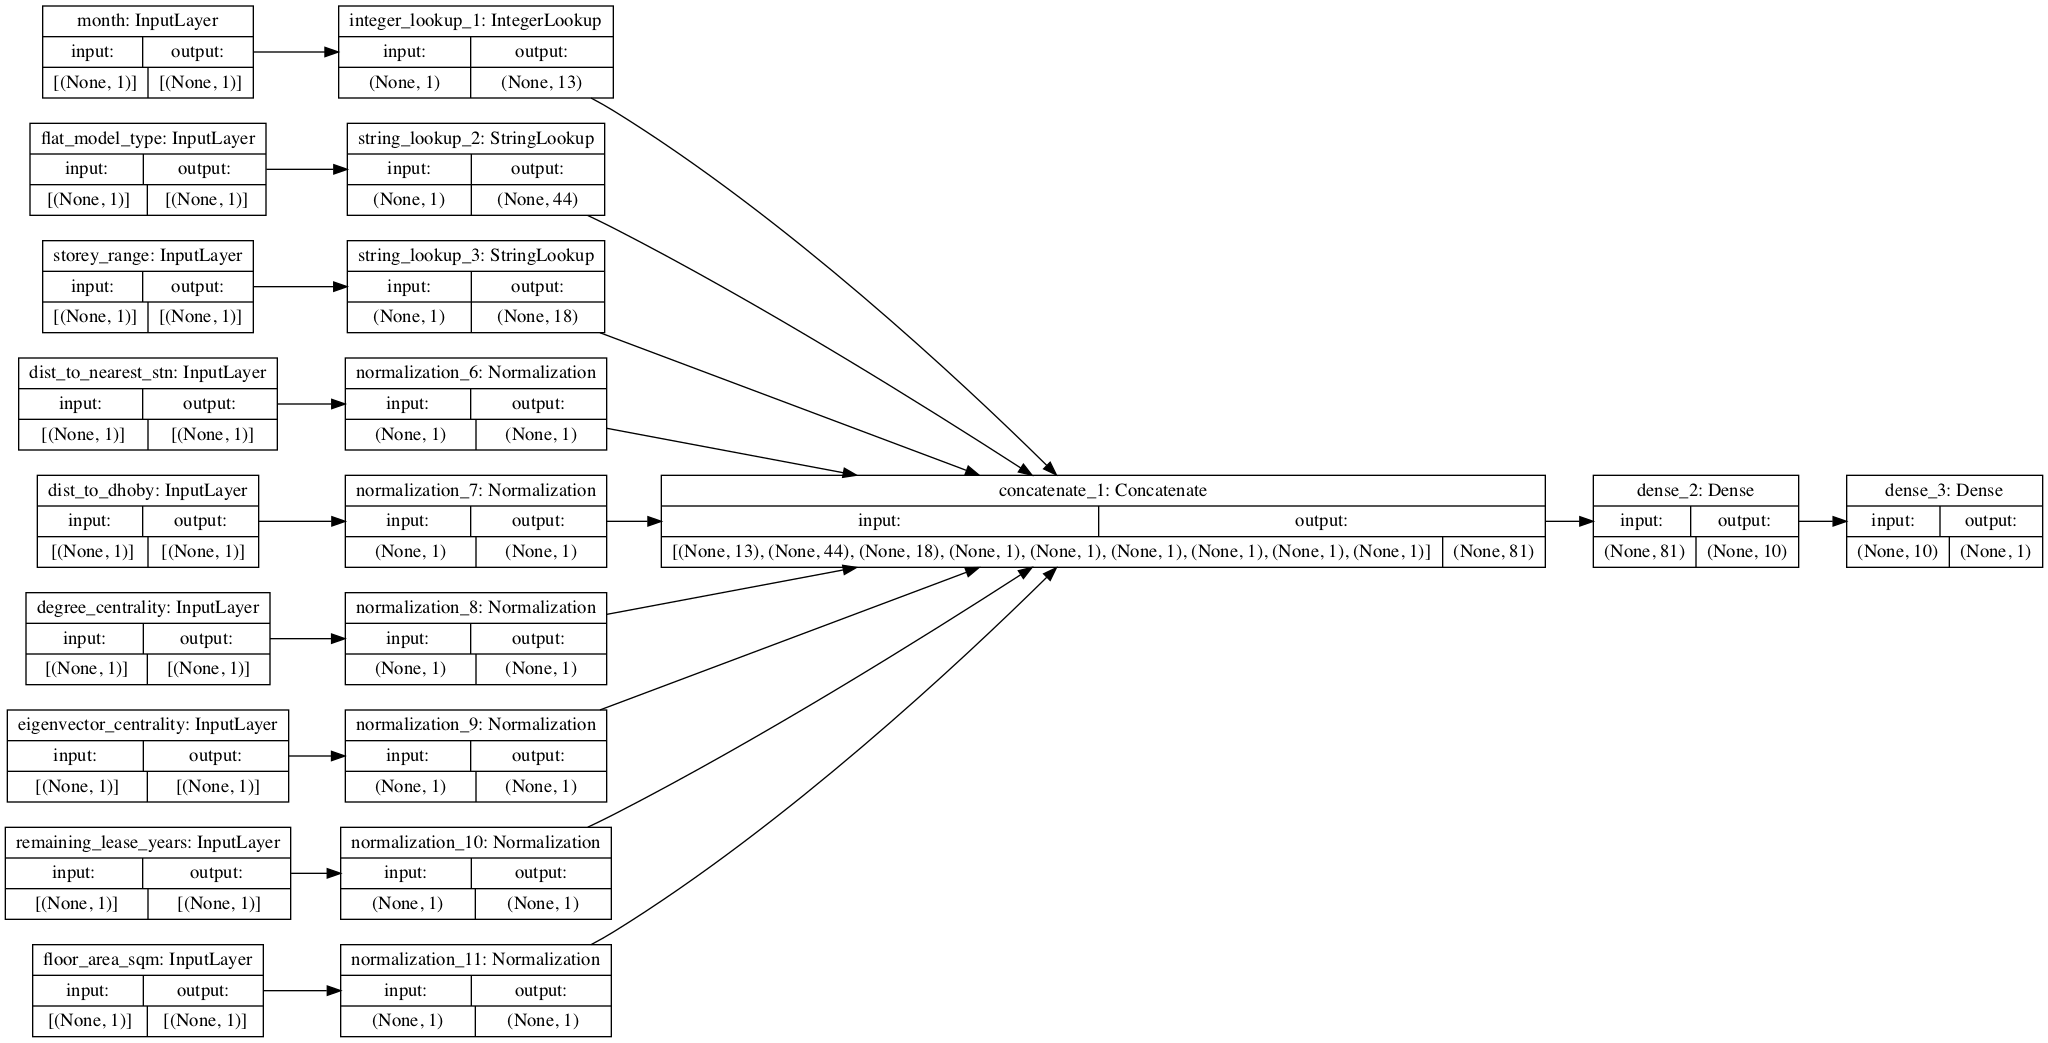

In [44]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [45]:
epochs = 100
callbacks = [model_checkpoint_callback]
verbose = 1
batch_size = 128

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, verbose=verbose, batch_size=batch_size)

Epoch 1/100
683/683 [==============================] - 3s 3ms/step - loss: 189632856064.0000 - root_mean_squared_error: 435468.5625 - coeff_determination: -7.1555 - val_loss: 175632465920.0000 - val_root_mean_squared_error: 419085.2812 - val_coeff_determination: -5.8907
INFO:tensorflow:Assets written to: nn-weights.01/assets
Epoch 2/100
683/683 [==============================] - 2s 2ms/step - loss: 69289803776.0000 - root_mean_squared_error: 263229.5625 - coeff_determination: -1.9701 - val_loss: 40588144640.0000 - val_root_mean_squared_error: 201465.0000 - val_coeff_determination: -0.5804
INFO:tensorflow:Assets written to: nn-weights.02/assets
Epoch 3/100
683/683 [==============================] - 2s 3ms/step - loss: 10976582656.0000 - root_mean_squared_error: 104769.1875 - coeff_determination: 0.5348 - val_loss: 11043729408.0000 - val_root_mean_squared_error: 105089.1484 - val_coeff_determination: 0.5734
INFO:tensorflow:Assets written to: nn-weights.03/assets
Epoch 4/100
683/683 [====

## Part D: Plotting RMSE against Epochs

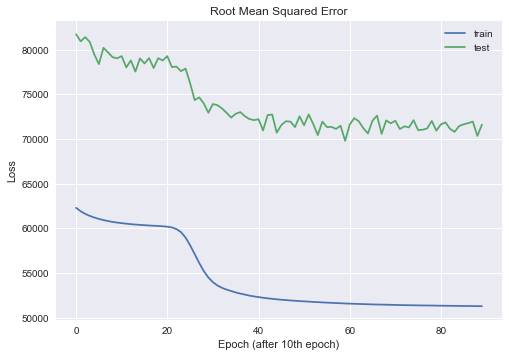

In [46]:
plt.style.use("seaborn")

# Extracting Train & Test RMSE from model history
rmse = history.history['root_mean_squared_error'][10:]
val_rmse = history.history['val_root_mean_squared_error'][10:]

# Plotting
plt.plot(rmse)
plt.plot(val_rmse)

# Labelling
plt.title('Root Mean Squared Error')
plt.ylabel('Loss')
plt.xlabel('Epoch (after 10th epoch)')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

## Part E: Epoch with Lowest Test Error

In [47]:
# Extracting Train & Test RMSE from model history
val_rmse = history.history['val_root_mean_squared_error']
val_r2 = history.history['val_coeff_determination']

# Getting the epoch with the lowest RMSE
index_min = np.argmin(val_rmse) 

# Printing
print("----------------------------")
print("Epoch: " , index_min+1, "th Epoch")
print("Root Mean Squared Error: %0.3f" % val_rmse[index_min])
print("R2 (Coefficient of Determination): %0.3f" % val_r2[index_min])
print("----------------------------")

----------------------------
Epoch:  70 th Epoch
Root Mean Squared Error: 69803.242
R2 (Coefficient of Determination): 0.809
----------------------------


## Part F: Making Predictions by using the Best Model

In [48]:
best_epoch = index_min+1
print("Loading model at Epoch: %0.0f" % best_epoch)

# Extracting root path of computer to find the correct folder across different computers/operating systems. 
abs_path = os.path.abspath('')
model_path = Path(abs_path) / ('nn-weights.' + str(best_epoch))

# Loading model
model_reloaded = keras.models.load_model(model_path, custom_objects={'coeff_determination': dummy_coeff_determination})

Loading model at Epoch: 70


In [49]:
# Extract a batch of 128 samples
iterator = iter(val_ds)
data_X, data_y = iterator.get_next()
predictions = model_reloaded.predict(data_X)

No handles with labels found to put in legend.


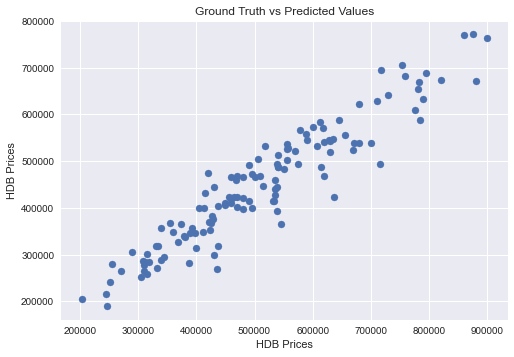

In [50]:
plt.style.use("seaborn")

# Plotting
plt.scatter(data_y, predictions)

# Labelling
plt.title('Ground Truth vs Predicted Values')
plt.ylabel('HDB Prices')
plt.xlabel('HDB Prices')

plt.legend()

## End of Part B, Question 1. 